# Song recommender

In [1]:
import pandas as pd
import numpy as np

import spotipy
import pickle
from tqdm.auto import tqdm

import modelling
import ux
import scraping as sc
import helper_functions as hf
import data_handler as dh
import spotifyhandler as sh

from matplotlib import pyplot
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
# Run Marker
update_bb_top100 = False
update_wiki_artist = False
update_song_list = False
update_audio_features = False
create_words_list = False
train_kmean = False
fit_scaler = True

In [3]:
# Load existing files


In [4]:
#sc.recommend_song()

In [5]:
if update_wiki_artist:
    artist_Series = sc.load_or_scrape('wiki_artist')['artists']
    artist_list = list(artist_Series)

In [6]:
if update_song_list:
    song_list = sh.search_songs(artist_list)
    len(song_list)

In [7]:
if create_words_list:
    print('create words list')
    words_list = hf.txt_to_list('data/speeches.txt')
    len(words_list)

In [8]:
if create_words_list:    
    song_list_update = sh.search_songs(words_list)
    len(song_list_update)


In [9]:
## concat multiple csvs and concat it to original df
if update_audio_features:
    df_complete_update = dh.concat_csvs('audio_features_update',25)
    df_complete_update.shape
    dh.update_audiofeatures_csv(df_complete_update)

### Load audiofeatures csv into df

In [10]:
df_audiofeatures = pd.read_csv('data/audio_features.csv')
print(df_audiofeatures.shape)
df_audiofeatures.head(3)

(275081, 20)


,artists,song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Wings,Mull Of Kintyre - Remastered 1993,0.350,0.297,2,-13.781,1,0.0265,0.000285,0.0000,0.123,0.423,90.603,audio_features,5yrgufPBA1PqSIOHZHrkYa,spotify:track:5yrgufPBA1PqSIOHZHrkYa,https://api.spotify.com/v1/tracks/5yrgufPBA1Pq...,https://api.spotify.com/v1/audio-analysis/5yrg...,282533,3
1,Ben Folds Five,"Selfless, Cold and Composed",0.233,0.497,11,-9.508,1,0.0322,0.361000,0.0288,0.076,0.272,180.779,audio_features,43Fd2LMelrD0HU01n4g4cw,spotify:track:43Fd2LMelrD0HU01n4g4cw,https://api.spotify.com/v1/tracks/43Fd2LMelrD0...,https://api.spotify.com/v1/audio-analysis/43Fd...,370347,3
2,Jimmy Cliff,Give And Take,0.833,0.559,2,-13.320,1,0.0688,0.087000,0.0000,0.333,0.652,127.907,audio_features,2YYtbzCV6jKwemSv6JoI8R,spotify:track:2YYtbzCV6jKwemSv6JoI8R,https://api.spotify.com/v1/tracks/2YYtbzCV6jKw...,https://api.spotify.com/v1/audio-analysis/2YYt...,133333,4


### Train scaler on audiofeatures df

In [11]:
# first strip of df of unessessary columns
X = modelling.to_feature_df(df_audiofeatures)

if fit_scaler:
    # fit scaler to df
    scaler = modelling.fit_scaler(X)

# transform df
X_scaled = modelling.scale(X)

### Train Model on audiofeatures df

In [12]:
k = 29
if train_kmean:
    kmeans = modelling.train_kmeans(X_scaled, number_clusters=k)
    len(kmeans.labels_)
else:
    try:
        kmeans = modelling.load_kmeans(number_clusters=k)
    except:
        kmeans = modelling.train_kmeans(X_scaled, number_clusters=k)

In [13]:
# assign a cluster to each example
labels = kmeans.predict(X_scaled)
labels

array([4, 4, 0, ..., 6, 1, 2])

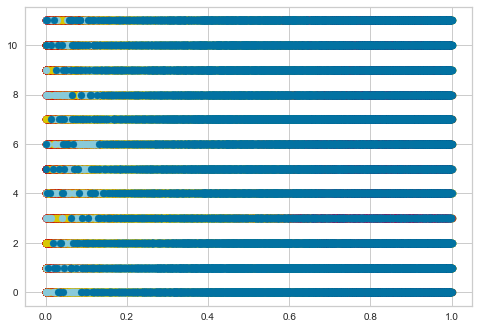

In [14]:
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(X.to_numpy()[row_ix, 1], X.to_numpy()[row_ix, 2])
    # show the plot
pyplot.show()

In [15]:
clusters = kmeans.predict(X_scaled)
#clusters
pd.Series(clusters).value_counts().sort_index()

0    81030
1    16728
2    31462
3    59867
4    40110
5     8069
6    37815
dtype: int64

In [16]:
df_audiofeatures["cluster"] = clusters
df_audiofeatures.head()

,artists,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,cluster
0,Wings,Mull Of Kintyre - Remastered 1993,0.350,0.297,2,-13.781,1,0.0265,0.000285,0.0000,...,0.423,90.603,audio_features,5yrgufPBA1PqSIOHZHrkYa,spotify:track:5yrgufPBA1PqSIOHZHrkYa,https://api.spotify.com/v1/tracks/5yrgufPBA1Pq...,https://api.spotify.com/v1/audio-analysis/5yrg...,282533,3,4
1,Ben Folds Five,"Selfless, Cold and Composed",0.233,0.497,11,-9.508,1,0.0322,0.361000,0.0288,...,0.272,180.779,audio_features,43Fd2LMelrD0HU01n4g4cw,spotify:track:43Fd2LMelrD0HU01n4g4cw,https://api.spotify.com/v1/tracks/43Fd2LMelrD0...,https://api.spotify.com/v1/audio-analysis/43Fd...,370347,3,4
2,Jimmy Cliff,Give And Take,0.833,0.559,2,-13.320,1,0.0688,0.087000,0.0000,...,0.652,127.907,audio_features,2YYtbzCV6jKwemSv6JoI8R,spotify:track:2YYtbzCV6jKwemSv6JoI8R,https://api.spotify.com/v1/tracks/2YYtbzCV6jKw...,https://api.spotify.com/v1/audio-analysis/2YYt...,133333,4,0
3,SHINee,SUPERSTAR,0.726,0.796,5,-3.853,0,0.0741,0.087900,0.0000,...,0.868,110.010,audio_features,7jiV2MnieeHtnYqTrXmQHD,spotify:track:7jiV2MnieeHtnYqTrXmQHD,https://api.spotify.com/v1/tracks/7jiV2MnieeHt...,https://api.spotify.com/v1/audio-analysis/7jiV...,174707,4,3
4,Electric Light Orchestra,So Serious,0.697,0.866,0,-7.632,1,0.0354,0.207000,0.0000,...,0.850,128.185,audio_features,2jo3bwXAGhVPL1Uh3dBWiB,spotify:track:2jo3bwXAGhVPL1Uh3dBWiB,https://api.spotify.com/v1/tracks/2jo3bwXAGhVP...,https://api.spotify.com/v1/audio-analysis/2jo3...,161773,4,0


In [17]:
df_audiofeatures[df_audiofeatures['cluster'] == 2].sample()

,artists,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,cluster
237028,Dreamy Thoughts,Spring,0.158,0.00183,2,-35.84,0,0.0388,0.992,0.799,...,0.0729,75.093,audio_features,2THMumd2UduUKZAtAgb2Kh,spotify:track:2THMumd2UduUKZAtAgb2Kh,https://api.spotify.com/v1/tracks/2THMumd2UduU...,https://api.spotify.com/v1/audio-analysis/2THM...,130909,5,2


## Chosing K

We have used K=8 by default for now - but we know that 8 might not be the optimal number of clusters for our dataset. Having a metric like inertia, we can compute it for several K values and then use the "elbow method" to choose the best K.

We will now leave all other parameters with their default value, since it seems to work pretty well.

In [18]:
# K = range(2, 21)
# inertia = []

# for k in K:
#     print("Training a K-Means model with {} clusters! ".format(k))
#     print()
#     kmeans = KMeans(n_clusters=k,
#                     random_state=1234)
#     kmeans.fit(X_scaled)
#     inertia.append(kmeans.inertia_)

# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.figure(figsize=(16,8))
# plt.plot(K, inertia, 'bx-')
# plt.xlabel('k')
# plt.ylabel('inertia')
# plt.xticks(np.arange(min(K), max(K)+1, 1.0))
# plt.title('Elbow Method showing the optimal k')

## Silouhette

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

K = range(2, 30)
silhouette = []

In [20]:
X_scaled_sample = X_scaled.sample(1000)
for k in tqdm(K):
    if train_kmean:
        kmeans = modelling.train_kmeans(X_scaled, number_clusters=k)
    else:
        kmeans = modelling.load_kmeans(number_clusters=k)
    silhouette.append(silhouette_score(X_scaled_sample, kmeans.predict(X_scaled_sample)))

100%|██████████| 28/28 [00:03<00:00,  7.75it/s]


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

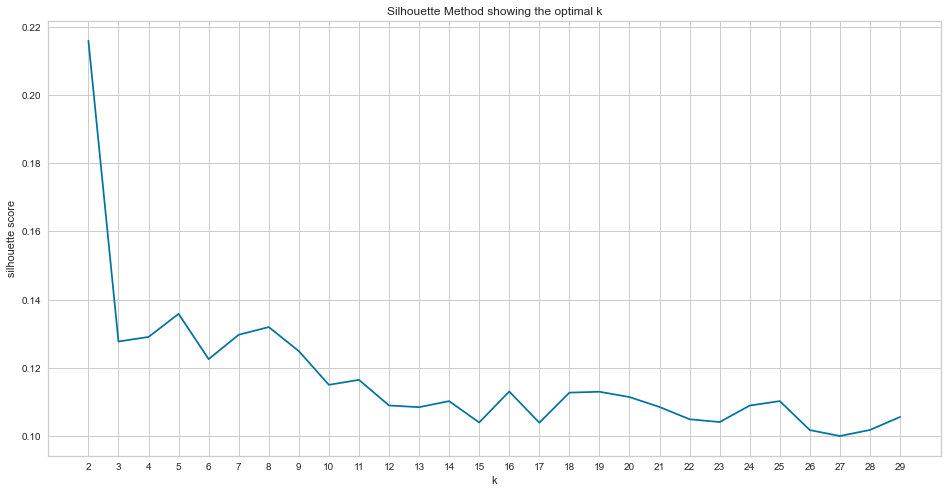

In [21]:
plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

### get cluster and recommend a song

In [22]:
kmeans = modelling.load_kmeans(number_clusters=k)


In [23]:
random_song = df_audiofeatures.sample()
random_song

,artists,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,cluster
19787,Preston,Chordalfloral - Mise en Scene Remix,0.609,0.52,2,-12.373,0,0.0692,0.13,0.893,...,0.83,180.042,audio_features,5g5tgP5mCxoJtQbNOngfcr,spotify:track:5g5tgP5mCxoJtQbNOngfcr,https://api.spotify.com/v1/tracks/5g5tgP5mCxoJ...,https://api.spotify.com/v1/audio-analysis/5g5t...,239000,4,6


In [24]:
random_song = modelling.to_feature_df(random_song)


In [25]:
cluster = modelling.give_cluster(random_song,kmeans)[0]
cluster

23

In [26]:
df_audiofeatures[df_audiofeatures['cluster'] == cluster].sample()

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
df_audiofeatures

,artists,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,cluster
0,Wings,Mull Of Kintyre - Remastered 1993,0.350,0.2970,2,-13.781,1,0.0265,0.000285,0.000000,...,0.4230,90.603,audio_features,5yrgufPBA1PqSIOHZHrkYa,spotify:track:5yrgufPBA1PqSIOHZHrkYa,https://api.spotify.com/v1/tracks/5yrgufPBA1Pq...,https://api.spotify.com/v1/audio-analysis/5yrg...,282533,3,4
1,Ben Folds Five,"Selfless, Cold and Composed",0.233,0.4970,11,-9.508,1,0.0322,0.361000,0.028800,...,0.2720,180.779,audio_features,43Fd2LMelrD0HU01n4g4cw,spotify:track:43Fd2LMelrD0HU01n4g4cw,https://api.spotify.com/v1/tracks/43Fd2LMelrD0...,https://api.spotify.com/v1/audio-analysis/43Fd...,370347,3,4
2,Jimmy Cliff,Give And Take,0.833,0.5590,2,-13.320,1,0.0688,0.087000,0.000000,...,0.6520,127.907,audio_features,2YYtbzCV6jKwemSv6JoI8R,spotify:track:2YYtbzCV6jKwemSv6JoI8R,https://api.spotify.com/v1/tracks/2YYtbzCV6jKw...,https://api.spotify.com/v1/audio-analysis/2YYt...,133333,4,0
3,SHINee,SUPERSTAR,0.726,0.7960,5,-3.853,0,0.0741,0.087900,0.000000,...,0.8680,110.010,audio_features,7jiV2MnieeHtnYqTrXmQHD,spotify:track:7jiV2MnieeHtnYqTrXmQHD,https://api.spotify.com/v1/tracks/7jiV2MnieeHt...,https://api.spotify.com/v1/audio-analysis/7jiV...,174707,4,3
4,Electric Light Orchestra,So Serious,0.697,0.8660,0,-7.632,1,0.0354,0.207000,0.000000,...,0.8500,128.185,audio_features,2jo3bwXAGhVPL1Uh3dBWiB,spotify:track:2jo3bwXAGhVPL1Uh3dBWiB,https://api.spotify.com/v1/tracks/2jo3bwXAGhVP...,https://api.spotify.com/v1/audio-analysis/2jo3...,161773,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275076,E-17,Each Time,0.667,0.8300,11,-6.218,1,0.0309,0.077700,0.000011,...,0.6580,100.188,audio_features,3vkqxWX7KS7pvEYGqI0z6z,spotify:track:3vkqxWX7KS7pvEYGqI0z6z,https://api.spotify.com/v1/tracks/3vkqxWX7KS7p...,https://api.spotify.com/v1/audio-analysis/3vkq...,228173,4,0
275077,Cstephh,Build Regimes Freestyle,0.638,0.1960,11,-24.406,1,0.3450,0.296000,0.000000,...,0.3110,140.600,audio_features,3EeivRbcCgxHeZF10n3wpG,spotify:track:3EeivRbcCgxHeZF10n3wpG,https://api.spotify.com/v1/tracks/3EeivRbcCgxH...,https://api.spotify.com/v1/audio-analysis/3Eei...,185111,5,4
275078,tstewart,Jess,0.569,0.8640,1,-5.716,0,0.0334,0.183000,0.632000,...,0.2710,103.013,audio_features,6bQ5MVqfN49AaBWZJRjarP,spotify:track:6bQ5MVqfN49AaBWZJRjarP,https://api.spotify.com/v1/tracks/6bQ5MVqfN49A...,https://api.spotify.com/v1/audio-analysis/6bQ5...,324320,4,6
275079,CityAlight,The Goodness of Jesus,0.306,0.3560,0,-8.726,1,0.0277,0.871000,0.000000,...,0.1190,140.266,audio_features,6iL4Am7n9div8eH9kxmDYS,spotify:track:6iL4Am7n9div8eH9kxmDYS,https://api.spotify.com/v1/tracks/6iL4Am7n9div...,https://api.spotify.com/v1/audio-analysis/6iL4...,259594,4,1


In [30]:
ux.ask_if_correct_song('The End Is Anguish',df_audiofeatures,'name')

artists


AttributeError: 'str' object has no attribute 'artist'

In [ ]:
song = 'Jess'

In [ ]:
song in list(df_audiofeatures.name)

True

In [ ]:
df_audiofeatures[df_audiofeatures.name == song]

,artists,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,cluster
275078,tstewart,Jess,0.569,0.864,1,-5.716,0,0.0334,0.183,0.632,...,0.271,103.013,audio_features,6bQ5MVqfN49AaBWZJRjarP,spotify:track:6bQ5MVqfN49AaBWZJRjarP,https://api.spotify.com/v1/tracks/6bQ5MVqfN49A...,https://api.spotify.com/v1/audio-analysis/6bQ5...,324320,4,6


In [ ]:
type(df_audiofeatures.name)

pandas.core.series.Series

In [ ]:
song = song.lower()

In [ ]:
song

'the end is anguish'